Start training...
Epoch [1/20], D Loss: 0.2326, G Loss: 3.4058


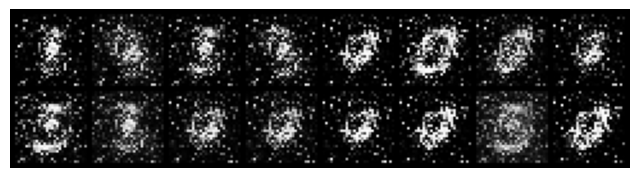

KeyboardInterrupt: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
latent_dim = 10
batch_size = 32
epochs = 20
learning_rate = 2e-4

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(
    root='./datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.net(x)
        return x.view(-1, 1, 28, 28)  # Reshape to image dimensions

# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x).view(-1)

# Visualization function
def show_images(images):
    images = (images + 1) / 2  # Convert from [-1, 1] to [0, 1]
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(make_grid(images.detach().cpu(), padding=2, normalize=False).permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Initialize models and optimizers
G = Generator().to(device)
D = Discriminator().to(device)

optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.BCELoss()

print('Start training...')
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        current_batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Real images
        real_labels = torch.ones(current_batch_size, device=device)
        outputs_real = D(real_images)
        loss_real = criterion(outputs_real, real_labels)
        
        # Fake images
        z = torch.randn(current_batch_size, latent_dim, device=device)
        fake_images = G(z)
        fake_labels = torch.zeros(current_batch_size, device=device)
        outputs_fake = D(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)
        
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()
        
        # Train Generator
        optimizer_G.zero_grad()
        outputs = D(fake_images)
        loss_G = criterion(outputs, real_labels)
        loss_G.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")
    
    if epoch % 5 == 0 or epoch == 0:
        with torch.no_grad():
            test_z = torch.randn(16, latent_dim, device=device)
            fakes = G(test_z)
            show_images(fakes)

print('Training complete!')